In [176]:
%matplotlib inline 

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import glob
import sklearn

import shapefile
from matplotlib.patches import Polygon
import mpld3

from censusgeocode import CensusGeocode

### 311 Request files

In [2]:
requests = pd.read_csv('get_it_done.csv')

In [3]:
len(requests)

10833

In [159]:
requests[['Problem Category', 'Case Number']].groupby('Problem Category').count().sort_values(by='Case Number')

,Case Number
Problem Category,
Litter/Dumping,27
Damaged Guardrail,52
Street Flooded,78
Faded striping,163
Street Sweeping,222
Storm Drain,233
Tree Hazard,668
Curb,750
Traffic Sign,789


In [160]:
graffiti = requests.loc[np.where(requests['Problem Category']=='Graffiti')[0]]
graffiti.reset_index(drop=True, inplace=True)

dump = requests.loc[np.where(requests['Problem Category']=='Litter/Dumping')[0]]
dump.reset_index(drop=True, inplace=True)

lighting = requests.loc[np.where(requests['Problem Category']=='Street Light')[0]]
lighting.reset_index(drop=True, inplace=True)

In [161]:
lighting.head()

,Case Number,Problem Category,Geolocation (Latitude),Geolocation (Longitude),Opened Date,Subject,Status,Public Description,SAP URL,Closed Date,Age (Days)
0,96441,Street Light,32.711461,-117.167053,7/28/16,Street Light Light Out at 467-499 West Market ...,Assigned,All 3 street lights out as well as tree lights...,https://getitdone.force.com//TSWViewReportDeta...,NaN,33
1,96442,Street Light,32.736961,-117.222571,7/28/16,Street Light Light Out at 3230 Whittier Street...,Assigned,street light has been out for over a week. No...,https://getitdone.force.com//TSWViewReportDeta...,NaN,33
2,96443,Street Light,32.751962,-117.223587,7/28/16,"Street Light Light Out at 2877 Barnard Street,...",Assigned,The entire street is not lit at 8:45pm at nigh...,https://getitdone.force.com//TSWViewReportDeta...,NaN,33
3,96451,Street Light,32.913565,-117.138534,7/28/16,"Light Out at 8575 NEW SALEM ST, 92126",Closed,LIGHTS OUT AT BASKET BALL COURT IN MIRA MESA PARK,https://getitdone.force.com//TSWViewReportDeta...,8/27/16,29
4,96456,Street Light,32.748780,-117.079541,7/29/16,Street Light Light Out at 54th and university ...,Duplicate,Lights out on all 4 corners of 54th street and...,https://getitdone.force.com//TSWViewReportDeta...,NaN,32


In [202]:
from sklearn.cluster import DBSCAN, KMeans
from sklearn import metrics
from sklearn.datasets.samples_generator import make_blobs
from sklearn.preprocessing import StandardScaler

In [203]:
X = StandardScaler().fit_transform(graffiti[['Geolocation (Longitude)', 'Geolocation (Latitude)']])

(-117.5, -116.7)

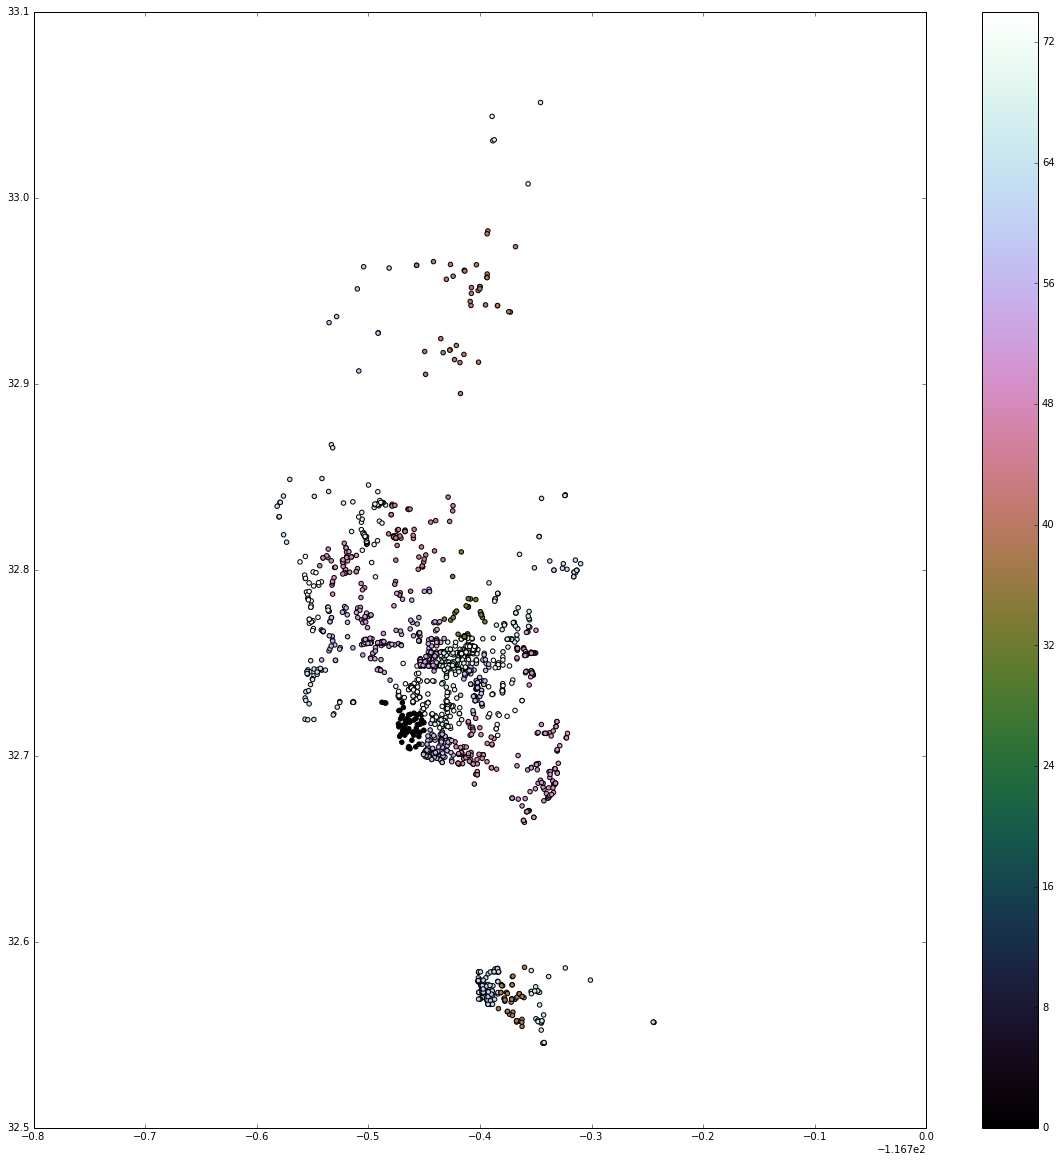

In [221]:
X = graffiti[['Geolocation (Longitude)', 'Geolocation (Latitude)']]
X = StandardScaler().fit_transform(graffiti[['Geolocation (Longitude)', 'Geolocation (Latitude)']])
random_state = 170
# Incorrect number of clusters
y_pred = KMeans(n_clusters=75, random_state=random_state).fit_predict(X)

plt.subplots(1,1, figsize=(20,20))
plt.scatter(X['Geolocation (Longitude)'], X['Geolocation (Latitude)'], c=y_pred, cmap='cubehelix')
plt.colorbar()

plt.ylim(32.5,33.1)
plt.xlim(-117.5,-116.7)

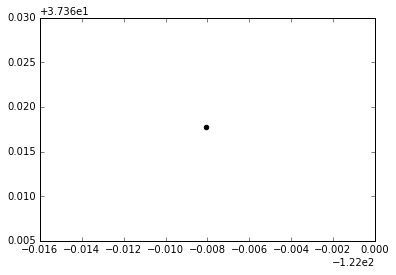

In [232]:
indexer = np.where(y_pred==51)[0]
plt.scatter(X.loc[indexer, 'Geolocation (Longitude)'], X.loc[indexer, 'Geolocation (Latitude)'], c=y_pred[indexer],
            cmap='cubehelix')



In [196]:
# Compute DBSCAN
db = DBSCAN(eps=0.1, min_samples=10).fit(X)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_

In [197]:
# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
print n_clusters_

1


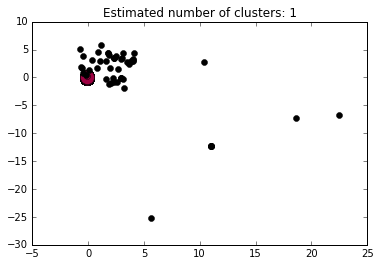

In [198]:
unique_labels = set(labels)
colors = plt.cm.Spectral(np.linspace(0, 1, len(unique_labels)))
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = 'k'

    class_member_mask = (labels == k)

    xy = X[class_member_mask & core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=col,
             markeredgecolor='k', markersize=14)

    xy = X[class_member_mask & ~core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=col,
             markeredgecolor='k', markersize=6)

plt.title('Estimated number of clusters: %d' % n_clusters_)
plt.show()


(-117.5, -116.7)

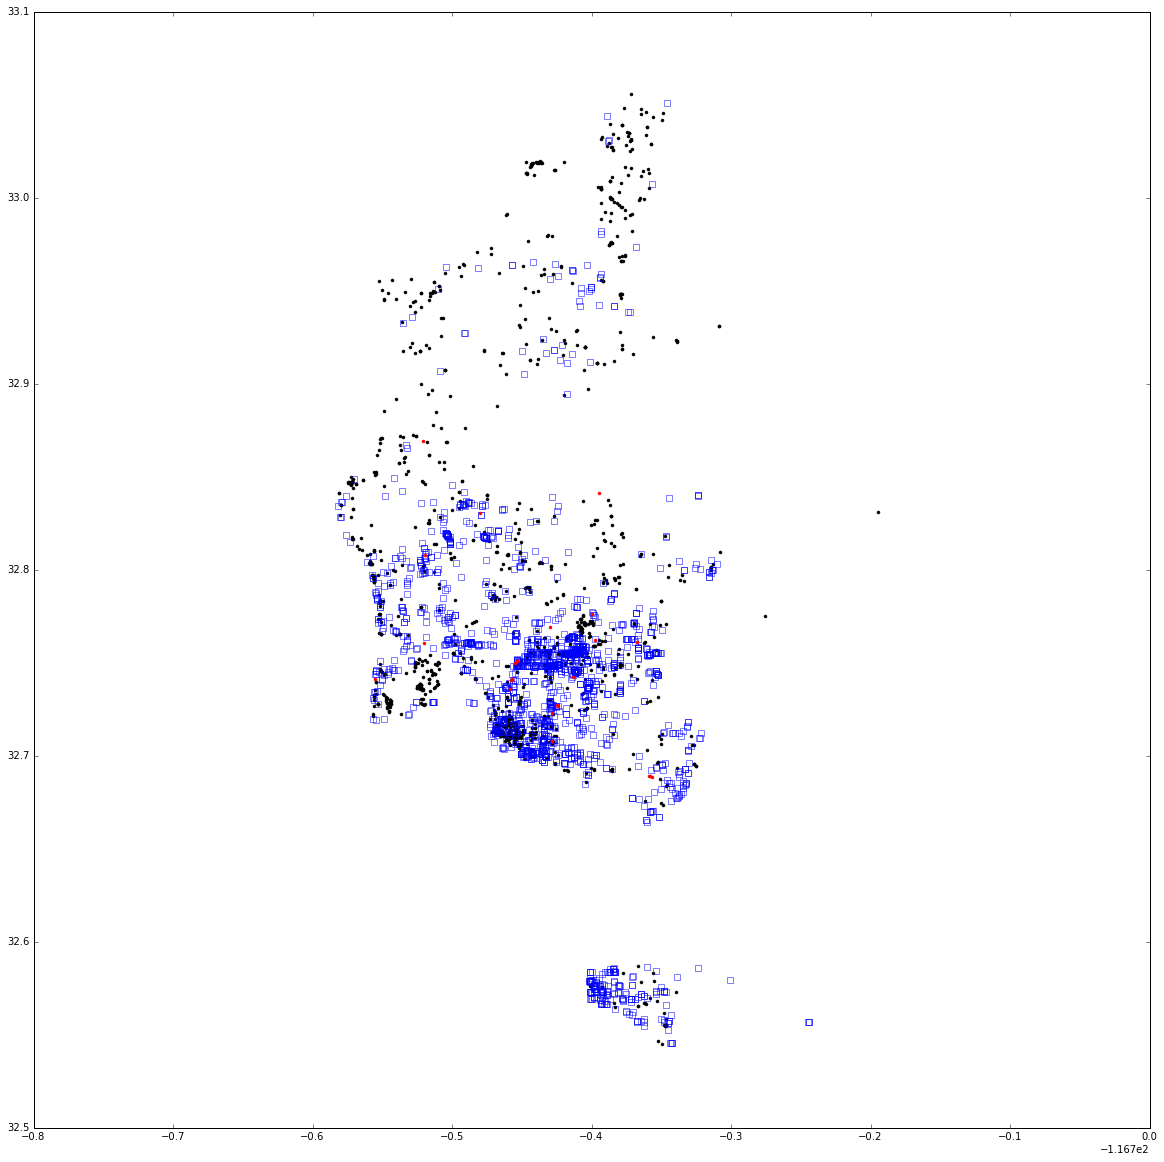

In [175]:
fig = plt.subplots(1,1, figsize=(20,20))

plt.plot(lighting['Geolocation (Longitude)'], lighting['Geolocation (Latitude)'], 'k.')
plt.plot(graffiti['Geolocation (Longitude)'], graffiti['Geolocation (Latitude)'], 'bs', mfc='none', mec='b')
plt.plot(dump['Geolocation (Longitude)'], dump['Geolocation (Latitude)'], 'r.')

plt.ylim(32.5,33.1)
plt.xlim(-117.5,-116.7)

### Extract Census linking information for request locations 

CensusGeocode

In [21]:
cg = CensusGeocode()

In [9]:
graffiti.loc[0,['Geolocation (Longitude)', 'Geolocation (Latitude)']].astype(float)

Geolocation (Longitude)   -117.106023
Geolocation (Latitude)      32.695569
Name: 0, dtype: float64

In [233]:
cg = CensusGeocode()

cg.coordinates(x=-76, y=41)
#cg.onelineaddress('1600 Pennsylvania Avenue, Washington, DC')
#cg.address('1600 Pennsylvania Avenue', city='Washington', state='DC', zipcode='22052')

ValueError: No JSON object could be decoded

In [144]:
graffiti['block']=None
graffiti['tract']=None
graffiti['geoid']=None

for i in range(0,10): 
    if (graffiti.loc[i,'Geolocation (Longitude)']!=0.0) :
        temp = cg.coordinates(x=graffiti.loc[i,'Geolocation (Longitude)'], 
                              y=graffiti.loc[i, 'Geolocation (Latitude)'])[0]['2010 Census Blocks'][0]
        graffiti.loc[i, 'block'] = temp['BLOCK']
        graffiti.loc[i, 'tract'] = temp['TRACT']
        graffiti.loc[i, 'geoid'] = temp['GEOID']

ValueError: No JSON object could be decoded

### Census information 

factfinder.census.gov

Organised by BLOCK

In [23]:
filenames='aff/blocks/D*with_ann.csv'
test=glob.glob(filenames)

In [24]:
for i in range(0,len(test)): 
    temp = pd.read_csv(test[i], header=1, low_memory=False)
    print i, i, i 
    if (i==0): 
        census = temp.copy()
    if (i!=0): 
        combo = pd.merge(census, temp, on='Id', how='left', suffixes=('', '_' + str(i)))
        census = combo.copy()
        census.reset_index(drop=True)

0 0 0
1 1 1
2 2 2
3 3 3
4 4 4
5 5 5
6 6 6
7 7 7
8 8 8
9 9 9
10 10 10
11 11 11
12 12 12
13 13 13
14 14 14
15 15 15
16 16 16
17 17 17
18 18 18
19 19 19
20 20 20
21 21 21
22 22 22
23 23 23


In [26]:
census_trimmed = census[['Id', 'Id2', 'Geography', 'Total:', 'Owner occupied','Renter occupied',
                         'For seasonal, recreational, or occasional use','For migrant workers', 
                         'Other vacant','Householder who is White alone',
                         'Householder who is Black or African American alone',
                         'Householder who is American Indian and Alaska Native alone',
                         'Householder who is Asian alone',
                         'Householder who is Native Hawaiian and Other Pacific Islander alone',
                         'Householder who is Some other race alone','Householder who is Two or more races', 
                         'GEOGRAPHIC AREA CODES - Census Tract','GEOGRAPHIC AREA CODES - Block Group',
                         'GEOGRAPHIC AREA CODES - Block','GEOGRAPHIC AREA CODES - Urban Area',
                         'GEOGRAPHIC AREA CODES - Urban Area Type','GEOGRAPHIC AREA CODES - Urban/Rural',
                         'AREA CHARACTERISTICS - Population Count (100%)',
                         'AREA CHARACTERISTICS - Housing Unit Count (100%)',
                         'AREA CHARACTERISTICS - Internal Point (Latitude)',
                         'AREA CHARACTERISTICS - Internal Point (Longitude)',
                         'Total:_4', 'Occupied', 'Vacant','Population of one race:',
                         'Population of one race: - White alone',
                         'Population of one race: - Black or African American alone',
                         'Population of one race: - American Indian and Alaska Native alone',
                         'Population of one race: - Asian alone',
                         'Population of one race: - Native Hawaiian and Other Pacific Islander alone',
                         'Population of one race: - Some Other Race alone','Two or More Races:',
                         'Two or More Races: - Population of three races:',
                         'Two or More Races: - Population of four races:',
                         'Two or More Races: - Population of five races:',
                         'Two or More Races: - Population of six races:','Male:',
                         'Male: - Under 5 years', 'Male: - 5 to 9 years','Male: - 10 to 14 years', 
                         'Male: - 15 to 17 years','Male: - 18 and 19 years', 'Male: - 20 years', 
                         'Male: - 21 years','Male: - 22 to 24 years', 'Male: - 25 to 29 years',
                         'Male: - 30 to 34 years', 'Male: - 35 to 39 years','Male: - 40 to 44 years', 
                         'Male: - 45 to 49 years','Male: - 50 to 54 years', 'Male: - 55 to 59 years',
                         'Male: - 60 and 61 years', 'Male: - 62 to 64 years','Male: - 65 and 66 years', 
                         'Male: - 67 to 69 years','Male: - 70 to 74 years', 'Male: - 75 to 79 years',
                         'Male: - 80 to 84 years', 'Male: - 85 years and over', 'Female:','Female: - Under 5 years', 
                         'Female: - 5 to 9 years','Female: - 10 to 14 years', 'Female: - 15 to 17 years',
                         'Female: - 18 and 19 years', 'Female: - 20 years','Female: - 21 years', 
                         'Female: - 22 to 24 years','Female: - 25 to 29 years', 'Female: - 30 to 34 years',
                         'Female: - 35 to 39 years', 'Female: - 40 to 44 years','Female: - 45 to 49 years', 
                         'Female: - 50 to 54 years','Female: - 55 to 59 years', 'Female: - 60 and 61 years',
                         'Female: - 62 to 64 years', 'Female: - 65 and 66 years','Female: - 67 to 69 years', 
                         'Female: - 70 to 74 years','Female: - 75 to 79 years', 'Female: - 80 to 84 years',
                         'Female: - 85 years and over', 'Id2_12', 'Geography_12','Median age -- - Both sexes', 
                         'Median age -- - Male','Median age -- - Female', 'Total:_13','Under 18 years', 
                         '18 years and over', 'Id2_14', 'Geography_14','Total:_14', 'Family households:',
                         'Family households: - Husband-wife family','Family households: - Other family:',
                         'Family households: - Other family: - Male householder, no wife present',
                         'Family households: - Other family: - Female householder, no husband present',
                         'Nonfamily households:','Nonfamily households: - Householder living alone',
                         'Nonfamily households: - Householder not living alone', 'Urban:', 
                         'Urban: - Inside urbanized areas','Urban: - Inside urban clusters', 
                         'Rural','Not defined for this file','Total:_19','White alone', 
                         'Black or African American alone','American Indian and Alaska Native alone', 
                         'Asian alone','Native Hawaiian and Other Pacific Islander alone','Some Other Race alone', 
                         'Two or More Races', 'Id2_20','Geography_20', 'Total:_20', 'Not Hispanic or Latino',
                         'Hispanic or Latino', 'Id2_21', 'Geography_21','Number; TENURE - Occupied housing units',
                         'Percent; TENURE - Occupied housing units',
                         'Number; TENURE - Occupied housing units - Owned with a mortgage or loan',
                         'Percent; TENURE - Occupied housing units - Owned with a mortgage or loan',
                         'Number; TENURE - Occupied housing units - Owned free and clear',
                         'Percent; TENURE - Occupied housing units - Owned free and clear',
                         'Number; TENURE - Occupied housing units - Renter occupied',
                         'Percent; TENURE - Occupied housing units - Renter occupied',
                         'Number; HOUSEHOLD POPULATION - Occupied housing units',
                         'Percent; HOUSEHOLD POPULATION - Occupied housing units',
                         'Number; HOUSEHOLD POPULATION - Occupied housing units - Owner-occupied housing units',
                         'Percent; HOUSEHOLD POPULATION - Occupied housing units - Owner-occupied housing units',
                         'Number; HOUSEHOLD POPULATION - Occupied housing units - Renter-occupied housing units',
                         'Percent; HOUSEHOLD POPULATION - Occupied housing units - Renter-occupied housing units']]

In [31]:
census_trimmed[['Id', 'Id2', 'Median age -- - Male', 'GEOGRAPHIC AREA CODES - Block']]

,Id,Id2,Median age -- - Male,GEOGRAPHIC AREA CODES - Block
0,1000000US060730001001000,60730001001000,49.4,1000
1,1000000US060730001001001,60730001001001,50.5,1001
2,1000000US060730001001002,60730001001002,52.5,1002
3,1000000US060730001001003,60730001001003,49.5,1003
4,1000000US060730001001004,60730001001004,58.5,1004
5,1000000US060730001001005,60730001001005,55.5,1005
6,1000000US060730001001006,60730001001006,49.2,1006
7,1000000US060730001001007,60730001001007,47.5,1007
8,1000000US060730001001008,60730001001008,54.3,1008
9,1000000US060730001001009,60730001001009,59.0,1009


#### Organised by BLOCK GROUP

In [33]:
filenames='aff/block_groups/*with_ann.csv'
test=glob.glob(filenames)

In [34]:
for i in range(0,len(test)): 
    temp = pd.read_csv(test[i], header=1, low_memory=False)
    print i, i, i 
    if (i==0): 
        census = temp.copy()
    if (i!=0): 
        combo = pd.merge(census, temp, on='Id', how='left', suffixes=('', '_' + str(i)))
        census = combo.copy()
        census.reset_index(drop=True)

0 0 0
1 1 1
2 2 2
3 3 3
4 4 4
5 5 5
6 6 6
7 7 7
8 8 8
9 9 9
10 10 10
11 11 11
12 12 12
13 13 13
14 14 14
15 15 15
16 16 16
17 17 17
18 18 18


In [37]:
#census.columns.values

In [36]:
census_trimmed = census[['Id', 'Id2', 'Geography', 'Estimate; Total:','Margin of Error; Total:', 'Estimate; Male:',
                         'Margin of Error; Male:', 'Estimate; Male: - Under 5 years',
                         'Margin of Error; Male: - Under 5 years','Estimate; Male: - 5 to 9 years',
                         'Margin of Error; Male: - 5 to 9 years','Estimate; Male: - 10 to 14 years',
                         'Margin of Error; Male: - 10 to 14 years','Estimate; Male: - 15 to 17 years',
                         'Margin of Error; Male: - 15 to 17 years','Estimate; Male: - 18 and 19 years',
                         'Margin of Error; Male: - 18 and 19 years','Estimate; Male: - 20 years', 
                         'Margin of Error; Male: - 20 years','Estimate; Male: - 21 years', 
                         'Margin of Error; Male: - 21 years','Estimate; Male: - 22 to 24 years',
                         'Margin of Error; Male: - 22 to 24 years','Estimate; Male: - 25 to 29 years',
                         'Margin of Error; Male: - 25 to 29 years','Estimate; Male: - 30 to 34 years',
                         'Margin of Error; Male: - 30 to 34 years','Estimate; Male: - 35 to 39 years',
                         'Margin of Error; Male: - 35 to 39 years','Estimate; Male: - 40 to 44 years',
                         'Margin of Error; Male: - 40 to 44 years','Estimate; Male: - 45 to 49 years',
                         'Margin of Error; Male: - 45 to 49 years','Estimate; Male: - 50 to 54 years',
                         'Margin of Error; Male: - 50 to 54 years','Estimate; Male: - 55 to 59 years',
                         'Margin of Error; Male: - 55 to 59 years','Estimate; Male: - 60 and 61 years',
                         'Margin of Error; Male: - 60 and 61 years','Estimate; Male: - 62 to 64 years',
                         'Margin of Error; Male: - 62 to 64 years','Estimate; Male: - 65 and 66 years',
                         'Margin of Error; Male: - 65 and 66 years','Estimate; Male: - 67 to 69 years',
                         'Margin of Error; Male: - 67 to 69 years','Estimate; Male: - 70 to 74 years',
                         'Margin of Error; Male: - 70 to 74 years','Estimate; Male: - 75 to 79 years',
                         'Margin of Error; Male: - 75 to 79 years','Estimate; Male: - 80 to 84 years',
                         'Margin of Error; Male: - 80 to 84 years','Estimate; Male: - 85 years and over',
                         'Margin of Error; Male: - 85 years and over', 'Estimate; Female:','Margin of Error; Female:',
                         'Estimate; Female: - Under 5 years','Margin of Error; Female: - Under 5 years',
                         'Estimate; Female: - 5 to 9 years','Margin of Error; Female: - 5 to 9 years',
                         'Estimate; Female: - 10 to 14 years','Margin of Error; Female: - 10 to 14 years',
                         'Estimate; Female: - 15 to 17 years','Margin of Error; Female: - 15 to 17 years',
                         'Estimate; Female: - 18 and 19 years','Margin of Error; Female: - 18 and 19 years',
                         'Estimate; Female: - 20 years','Margin of Error; Female: - 20 years',
                         'Estimate; Female: - 21 years','Margin of Error; Female: - 21 years',
                         'Estimate; Female: - 22 to 24 years','Margin of Error; Female: - 22 to 24 years',
                         'Estimate; Female: - 25 to 29 years','Margin of Error; Female: - 25 to 29 years',
                         'Estimate; Female: - 30 to 34 years','Margin of Error; Female: - 30 to 34 years',
                         'Estimate; Female: - 35 to 39 years','Margin of Error; Female: - 35 to 39 years',
                         'Estimate; Female: - 40 to 44 years','Margin of Error; Female: - 40 to 44 years',
                         'Estimate; Female: - 45 to 49 years','Margin of Error; Female: - 45 to 49 years',
                         'Estimate; Female: - 50 to 54 years','Margin of Error; Female: - 50 to 54 years',
                         'Estimate; Female: - 55 to 59 years','Margin of Error; Female: - 55 to 59 years',
                         'Estimate; Female: - 60 and 61 years','Margin of Error; Female: - 60 and 61 years',
                         'Estimate; Female: - 62 to 64 years','Margin of Error; Female: - 62 to 64 years',
                         'Estimate; Female: - 65 and 66 years','Margin of Error; Female: - 65 and 66 years',
                         'Estimate; Female: - 67 to 69 years','Margin of Error; Female: - 67 to 69 years',
                         'Estimate; Female: - 70 to 74 years','Margin of Error; Female: - 70 to 74 years',
                         'Estimate; Female: - 75 to 79 years','Margin of Error; Female: - 75 to 79 years',
                         'Estimate; Female: - 80 to 84 years','Margin of Error; Female: - 80 to 84 years',
                         'Estimate; Female: - 85 years and over','Margin of Error; Female: - 85 years and over', 
                         'Id2_1','Geography_1', 'Estimate; Median age -- - Total:',
                         'Margin of Error; Median age -- - Total:','Estimate; Median age -- - Male',
                         'Margin of Error; Median age -- - Male','Estimate; Median age -- - Female',
                         'Margin of Error; Median age -- - Female', 'Id2_2', 'Geography_2','Estimate; Total', 
                         'Margin of Error; Total', 'Id2_3', 'Geography_3','Estimate; Total:_3', 
                         'Margin of Error; Total:_3','Estimate; Total: - White alone',
                         'Margin of Error; Total: - White alone','Estimate; Total: - Black or African American alone',
                         'Margin of Error; Total: - Black or African American alone',
                         'Estimate; Total: - American Indian and Alaska Native alone',
                         'Margin of Error; Total: - American Indian and Alaska Native alone',
                         'Estimate; Total: - Asian alone','Margin of Error; Total: - Asian alone',
                         'Estimate; Total: - Native Hawaiian and Other Pacific Islander alone',
                         'Margin of Error; Total: - Native Hawaiian and Other Pacific Islander alone',
                         'Estimate; Total: - Some other race alone','Margin of Error; Total: - Some other race alone',
                         'Estimate; Total: - Two or more races:','Margin of Error; Total: - Two or more races:',
                         'Estimate; Total: - Two or more races: - Two races including Some other race',
                         'Margin of Error; Total: - Two or more races: - Two races including Some other race',
                         'Estimate; Total: - Two or more races: - Two races excluding Some other race, and three or more races',
                         'Margin of Error; Total: - Two or more races: - Two races excluding Some other race, and three or more races',
                         'Id2_4', 'Geography_4', 'Estimate; Total:_4','Margin of Error; Total:_4', 'Estimate; Family households:',
                         'Margin of Error; Family households:','Estimate; Family households: - Married-couple family',
                         'Margin of Error; Family households: - Married-couple family','Estimate; Family households: - Other family:',
                         'Margin of Error; Family households: - Other family:',
                         'Estimate; Family households: - Other family: - Male householder, no wife present',
                         'Margin of Error; Family households: - Other family: - Male householder, no wife present',
                         'Estimate; Family households: - Other family: - Female householder, no husband present',
                         'Margin of Error; Family households: - Other family: - Female householder, no husband present',
                         'Estimate; Nonfamily households:','Margin of Error; Nonfamily households:',
                         'Estimate; Nonfamily households: - Householder living alone',
                         'Margin of Error; Nonfamily households: - Householder living alone',
                         'Estimate; Nonfamily households: - Householder not living alone',
                         'Margin of Error; Nonfamily households: - Householder not living alone','Id2_5', 
                         'Geography_5', 'Estimate; Total:_5','Margin of Error; Total:_5', 'Estimate; Enrolled in school:',
                         'Margin of Error; Enrolled in school:','Estimate; Enrolled in school: - Enrolled in college, undergraduate years',
                         'Margin of Error; Enrolled in school: - Enrolled in college, undergraduate years',
                         'Estimate; Enrolled in school: - Graduate or professional school',
                         'Margin of Error; Enrolled in school: - Graduate or professional school',
                         'Estimate; Not enrolled in school','Margin of Error; Not enrolled in school', 
                         'Estimate; Total: - English only','Margin of Error; Total: - English only',
                         'Estimate; Total: - Spanish:', 'Margin of Error; Total: - Spanish:',
                         'Estimate; Total: - Other Indo-European languages:',
                         'Margin of Error; Total: - Other Indo-European languages:',
                         'Estimate; Total: - Asian and Pacific Island languages:',
                         'Margin of Error; Total: - Asian and Pacific Island languages:','Estimate; Total: - Other languages:',
                         'Margin of Error; Total: - Other languages:','Estimate; Total: - Less than $10,000',
                         'Margin of Error; Total: - Less than $10,000','Estimate; Total: - $10,000 to $14,999',
                         'Margin of Error; Total: - $10,000 to $14,999','Estimate; Total: - $15,000 to $19,999',
                         'Margin of Error; Total: - $15,000 to $19,999','Estimate; Total: - $20,000 to $24,999',
                         'Margin of Error; Total: - $20,000 to $24,999','Estimate; Total: - $25,000 to $29,999',
                         'Margin of Error; Total: - $25,000 to $29,999','Estimate; Total: - $30,000 to $34,999',
                         'Margin of Error; Total: - $30,000 to $34,999','Estimate; Total: - $35,000 to $39,999',
                         'Margin of Error; Total: - $35,000 to $39,999','Estimate; Total: - $40,000 to $44,999',
                         'Margin of Error; Total: - $40,000 to $44,999','Estimate; Total: - $45,000 to $49,999',
                         'Margin of Error; Total: - $45,000 to $49,999','Estimate; Total: - $50,000 to $59,999',
                         'Margin of Error; Total: - $50,000 to $59,999','Estimate; Total: - $60,000 to $74,999',
                         'Margin of Error; Total: - $60,000 to $74,999','Estimate; Total: - $75,000 to $99,999',
                         'Margin of Error; Total: - $75,000 to $99,999','Estimate; Total: - $100,000 to $124,999',
                         'Margin of Error; Total: - $100,000 to $124,999','Estimate; Total: - $125,000 to $149,999',
                         'Margin of Error; Total: - $125,000 to $149,999','Estimate; Total: - $150,000 to $199,999',
                         'Margin of Error; Total: - $150,000 to $199,999','Estimate; Total: - $200,000 or more',
                         'Margin of Error; Total: - $200,000 or more', 'Id2_9','Geography_9',
                         'Estimate; Median household income in the past 12 months (in 2014 Inflation-adjusted dollars)',
                         'Margin of Error; Median household income in the past 12 months (in 2014 Inflation-adjusted dollars)',
                         'Estimate; Total: - With public assistance income',
                         'Margin of Error; Total: - With public assistance income',
                         'Estimate; Total: - No public assistance income',
                         'Margin of Error; Total: - No public assistance income', 
                         'Id2_11',
                         'Estimate; Per capita income in the past 12 months (in 2014 Inflation-adjusted dollars)',
                         'Margin of Error; Per capita income in the past 12 months (in 2014 Inflation-adjusted dollars)',
                         'Estimate; Total: - Owner occupied','Margin of Error; Total: - Owner occupied',
                         'Estimate; Total: - Renter occupied','Margin of Error; Total: - Renter occupied',
                         'Estimate; Total: - Householder who is White alone',
                         'Margin of Error; Total: - Householder who is White alone',
                         'Estimate; Total: - Householder who is Black or African American alone',
                         'Margin of Error; Total: - Householder who is Black or African American alone',
                         'Estimate; Total: - Householder who is American Indian and Alaska Native alone',
                         'Margin of Error; Total: - Householder who is American Indian and Alaska Native alone',
                         'Estimate; Total: - Householder who is Asian alone',
                         'Margin of Error; Total: - Householder who is Asian alone',
                         'Estimate; Total: - Householder who is Native Hawaiian and Other Pacific Islander alone',
                         'Margin of Error; Total: - Householder who is Native Hawaiian and Other Pacific Islander alone',
                         'Estimate; Total: - Householder who is Some other race alone',
                         'Margin of Error; Total: - Householder who is Some other race alone',
                         'Estimate; Total: - Householder who is Two or more races:',
                         'Margin of Error; Total: - Householder who is Two or more races:',
                         'Estimate; Total: - Householder who is Two or more races: - Householder who is Two races including Some other race',
                         'Margin of Error; Total: - Householder who is Two or more races: - Householder who is Two races including Some other race',
                         'Estimate; Total: - Householder who is Two or more races: - Householder who is Two races excluding Some other race, and three or more races',
                         'Margin of Error; Total: - Householder who is Two or more races: - Householder who is Two races excluding Some other race, and three or more races',
                         'GEOGRAPHIC AREA CODES - Census Tract','GEOGRAPHIC AREA CODES - Block Group',
                         'GEOGRAPHIC AREA CODES - Block']]

In [38]:
census_trimmed[['GEOGRAPHIC AREA CODES - Census Tract', 'GEOGRAPHIC AREA CODES - Block Group']]

,GEOGRAPHIC AREA CODES - Census Tract,GEOGRAPHIC AREA CODES - Block Group
0,100,1
1,100,2
2,201,1
3,202,1
4,202,2
5,202,3
6,300,1
7,300,2
8,300,3
9,300,4


In [108]:
requests[['block', 'tract', 'geoid']]

,block,tract,geoid
0,1009,017044,060730170441009
1,None,None,None
2,1004,008347,060730083471004
3,None,None,None
4,None,None,None
5,None,None,None
6,None,None,None
7,None,None,None
8,None,None,None
9,1004,008347,060730083471004


In [101]:
temp = cg.coordinates(x=requests.loc[0:5, 'long'], y=requests.loc[0:5, 'lat'])[0]['2010 Census Blocks'][0]['BLOCK']

In [104]:
cg.coordinates(x=requests.loc[0:5, 'long'], y=requests.loc[0:5, 'lat'])

1

In [116]:
census.loc[0:10, ['Id', 'Id2', 'Geography', 'GEOGRAPHIC AREA CODES - Block', 'GEOGRAPHIC AREA CODES - Urban/Rural']]

,Id,Id2,Geography,GEOGRAPHIC AREA CODES - Block,GEOGRAPHIC AREA CODES - Urban/Rural
0,1000000US060730001001000,60730001001000,"Block 1000, Block Group 1, Census Tract 1, San...",1000,
1,1000000US060730001001001,60730001001001,"Block 1001, Block Group 1, Census Tract 1, San...",1001,
2,1000000US060730001001002,60730001001002,"Block 1002, Block Group 1, Census Tract 1, San...",1002,
3,1000000US060730001001003,60730001001003,"Block 1003, Block Group 1, Census Tract 1, San...",1003,
4,1000000US060730001001004,60730001001004,"Block 1004, Block Group 1, Census Tract 1, San...",1004,
5,1000000US060730001001005,60730001001005,"Block 1005, Block Group 1, Census Tract 1, San...",1005,
6,1000000US060730001001006,60730001001006,"Block 1006, Block Group 1, Census Tract 1, San...",1006,
7,1000000US060730001001007,60730001001007,"Block 1007, Block Group 1, Census Tract 1, San...",1007,
8,1000000US060730001001008,60730001001008,"Block 1008, Block Group 1, Census Tract 1, San...",1008,
9,1000000US060730001001009,60730001001009,"Block 1009, Block Group 1, Census Tract 1, San...",1009,


In [115]:
census.columns.values

array(['Id', 'Id2', 'Geography', 'Total:', 'Owner occupied',
       'Renter occupied', 'Id2_1', 'Geography_1', 'Total:_1', 'For rent',
       'For sale only', 'Rented or sold, not occupied',
       'For seasonal, recreational, or occasional use',
       'For migrant workers', 'Other vacant', 'Id2_2', 'Geography_2',
       'Total:_2', 'Householder who is White alone',
       'Householder who is Black or African American alone',
       'Householder who is American Indian and Alaska Native alone',
       'Householder who is Asian alone',
       'Householder who is Native Hawaiian and Other Pacific Islander alone',
       'Householder who is Some other race alone',
       'Householder who is Two or more races', 'Id2_3', 'Geography_3',
       'RECORD CODES - File Identification',
       'RECORD CODES - State/US-Abbreviation (USPS)',
       'RECORD CODES - Summary Level',
       'RECORD CODES - Geographic Component',
       'RECORD CODES - Characteristic Iteration',
       'RECORD CODES - Ch

In [62]:
census.loc[0:10, ['Id', 'Id2', 'Geography', 'GEOGRAPHIC AREA CODES - Block Group', 'GEOGRAPHIC AREA CODES - Census Tract']]

,Id,Id2,Geography,GEOGRAPHIC AREA CODES - Block Group,GEOGRAPHIC AREA CODES - Census Tract
0,1500000US060730001001,60730001001,"Block Group 1, Census Tract 1, San Diego Count...",1,100
1,1500000US060730001002,60730001002,"Block Group 2, Census Tract 1, San Diego Count...",2,100
2,1500000US060730002011,60730002011,"Block Group 1, Census Tract 2.01, San Diego Co...",1,201
3,1500000US060730002021,60730002021,"Block Group 1, Census Tract 2.02, San Diego Co...",1,202
4,1500000US060730002022,60730002022,"Block Group 2, Census Tract 2.02, San Diego Co...",2,202
5,1500000US060730002023,60730002023,"Block Group 3, Census Tract 2.02, San Diego Co...",3,202
6,1500000US060730003001,60730003001,"Block Group 1, Census Tract 3, San Diego Count...",1,300
7,1500000US060730003002,60730003002,"Block Group 2, Census Tract 3, San Diego Count...",2,300
8,1500000US060730003003,60730003003,"Block Group 3, Census Tract 3, San Diego Count...",3,300
9,1500000US060730003004,60730003004,"Block Group 4, Census Tract 3, San Diego Count...",4,300


In [29]:
census.columns.values

array(['Id', 'Id2', 'Geography', 'Estimate; Total:',
       'Margin of Error; Total:', 'Estimate; Male:',
       'Margin of Error; Male:', 'Estimate; Male: - Under 5 years',
       'Margin of Error; Male: - Under 5 years',
       'Estimate; Male: - 5 to 9 years',
       'Margin of Error; Male: - 5 to 9 years',
       'Estimate; Male: - 10 to 14 years',
       'Margin of Error; Male: - 10 to 14 years',
       'Estimate; Male: - 15 to 17 years',
       'Margin of Error; Male: - 15 to 17 years',
       'Estimate; Male: - 18 and 19 years',
       'Margin of Error; Male: - 18 and 19 years',
       'Estimate; Male: - 20 years', 'Margin of Error; Male: - 20 years',
       'Estimate; Male: - 21 years', 'Margin of Error; Male: - 21 years',
       'Estimate; Male: - 22 to 24 years',
       'Margin of Error; Male: - 22 to 24 years',
       'Estimate; Male: - 25 to 29 years',
       'Margin of Error; Male: - 25 to 29 years',
       'Estimate; Male: - 30 to 34 years',
       'Margin of Error; Male:

### Census block Shapefiles

http://rdw.sandag.org/Account/gisdtview?dir=Census

In [42]:
reader = shapefile.Reader('shapefiles/CENSUS_BLOCKS_2010/CENSUS_BLOCKS_2010.shp')

### Census Block Group Shapefiles

In [243]:
reader = shapefile.Reader('shapefiles/tl_2016_06_bg/tl_2016_06_bg.shp')

In [244]:
shapes = reader.shapes()

In [245]:
len(shapes)

23212

In [380]:
reader.fields

[('DeletionFlag', 'C', 1, 0),
 ['STATEFP', 'C', 2, 0],
 ['COUNTYFP', 'C', 3, 0],
 ['TRACTCE', 'C', 6, 0],
 ['BLKGRPCE', 'C', 1, 0],
 ['GEOID', 'C', 12, 0],
 ['NAMELSAD', 'C', 13, 0],
 ['MTFCC', 'C', 5, 0],
 ['FUNCSTAT', 'C', 1, 0],
 ['ALAND', 'N', 14, 0],
 ['AWATER', 'N', 14, 0],
 ['INTPTLAT', 'C', 11, 0],
 ['INTPTLON', 'C', 12, 0]]

In the shapefile records: 
- 0: '06' is the State code
- 1: '031' is the County code (SD 073)
- 2: Tract
- 3: Block Group number 
- 4: GeoID 

can use reader.fields for a bit more info


In [246]:
bg_info = pd.DataFrame(reader.records())

In [354]:
sdcounty = bg_info.loc[np.where((bg_info[1]=='073') & (bg_info[3]!='0'))[0]]
sdcounty_index = np.where((bg_info[1]=='073') & (bg_info[3]!='0'))[0]

### Census + Block Group information

In [355]:
sdcounty.rename(columns={2: 'tract', 3: 'blockgroup'}, inplace=True)
census_trimmed.rename(columns={'GEOGRAPHIC AREA CODES - Census Tract': 'tract',
                               'GEOGRAPHIC AREA CODES - Block Group': 'blockgroup'}, inplace=True)

In [356]:
sdcounty.loc[:,'tract'] = sdcounty.loc[:,'tract'].astype(int)
sdcounty.loc[:,'blockgroup'] = sdcounty.loc[:,'blockgroup'].astype(int)

census_trimmed.loc[:,'tract'] = census_trimmed.loc[:,'tract'].astype(int)
census_trimmed.loc[:,'blockgroup'] = census_trimmed.loc[:,'blockgroup'].astype(int)

In [357]:
census_combo = pd.merge(sdcounty, census_trimmed, on=['tract', 'blockgroup'], how='left')

/Users/kschles/anaconda/lib/python2.7/site-packages/pandas/indexes/base.py:917: DeprecationWarning: unorderable dtypes; returning scalar but in the future this will be an error
  return self._engine.is_monotonic_increasing
/Users/kschles/anaconda/lib/python2.7/site-packages/pandas/indexes/base.py:917: DeprecationWarning: unorderable dtypes; returning scalar but in the future this will be an error
  return self._engine.is_monotonic_increasing


In [358]:
census_combo[['Estimate; Male:', 'Estimate; Female:','Estimate; Total: - White alone',
               'Estimate; Total: - Black or African American alone', 
               'Estimate; Total: - American Indian and Alaska Native alone', 
               'Estimate; Total: - Asian alone',
               'Estimate; Total: - Native Hawaiian and Other Pacific Islander alone',
               'Estimate; Total: - Some other race alone','Estimate; Total: - Two or more races:',
               'Estimate; Total: - Owner occupied']] = census_combo[['Estimate; Male:', 'Estimate; Female:',
                                                                     'Estimate; Total: - White alone',
                                                                     'Estimate; Total: - Black or African American alone', 
                                                                     'Estimate; Total: - American Indian and Alaska Native alone', 
                                                                     'Estimate; Total: - Asian alone',
                                                                     'Estimate; Total: - Native Hawaiian and Other Pacific Islander alone',
                                                                     'Estimate; Total: - Some other race alone','Estimate; Total: - Two or more races:',
                                                                     'Estimate; Total: - Owner occupied']].div(census_combo['Estimate; Total:'], axis=0)

In [359]:
from matplotlib.collections import PatchCollection

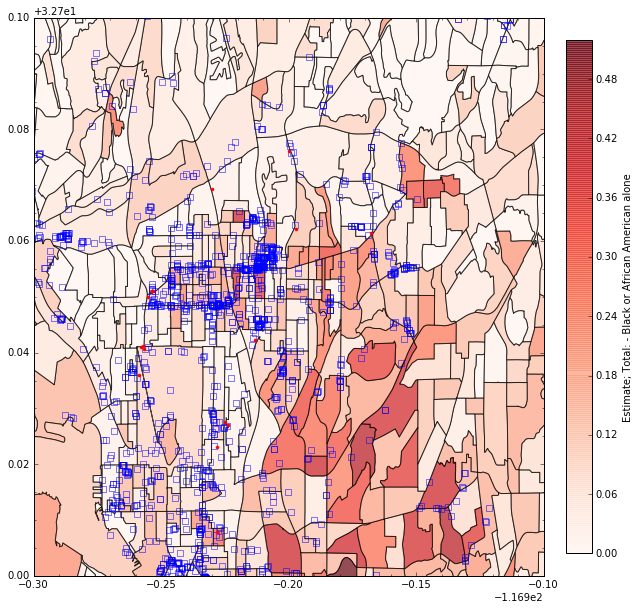

In [373]:
column_choice = 'Estimate; Total: - Black or African American alone'
fig,ax = plt.subplots(1,1, figsize=(10,10))
patches = []
for i in range(0,len(sdcounty_index)): 
    barf = pd.DataFrame(shapes[sdcounty_index[i]].points)
    poly = plt.Polygon(barf[[0,1]], fc='none', ec='k', alpha=0.7)
    patches.append(poly)
    #plt.gca().add_patch(poly)

colors = census_combo[column_choice]
p = PatchCollection(patches, cmap='Reds', alpha=0.7)
p.set_array(np.array(colors))
p.set_clim([min(colors),max(colors)])
ax.add_collection(p)
plt.colorbar(p, fraction=0.046, pad=0.04, shrink=1.0, label=column_choice)

#plt.plot(lighting['Geolocation (Longitude)'], lighting['Geolocation (Latitude)'], 'k.')
plt.plot(graffiti['Geolocation (Longitude)'], graffiti['Geolocation (Latitude)'], 'bs', mfc='none', mec='b')
plt.plot(dump['Geolocation (Longitude)'], dump['Geolocation (Latitude)'], 'r.')

plt.ylim(32.7,32.8)
plt.xlim(-117.2,-117.0)

#plt.axis('scaled')
plt.minorticks_on()

plt.show()

### Look at how different block groups cluster in terms of demographics

In [375]:
X = StandardScaler().fit_transform(census_combo[['Estimate; Male:', 'Estimate; Female:',
                                                 'Estimate; Total: - White alone',
                                                 'Estimate; Total: - Black or African American alone', 
                                                 'Estimate; Total: - American Indian and Alaska Native alone', 
                                                 'Estimate; Total: - Asian alone',
                                                 'Estimate; Total: - Native Hawaiian and Other Pacific Islander alone',
                                                 'Estimate; Total: - Some other race alone','Estimate; Total: - Two or more races:',
                                                 'Estimate; Total: - Owner occupied']])



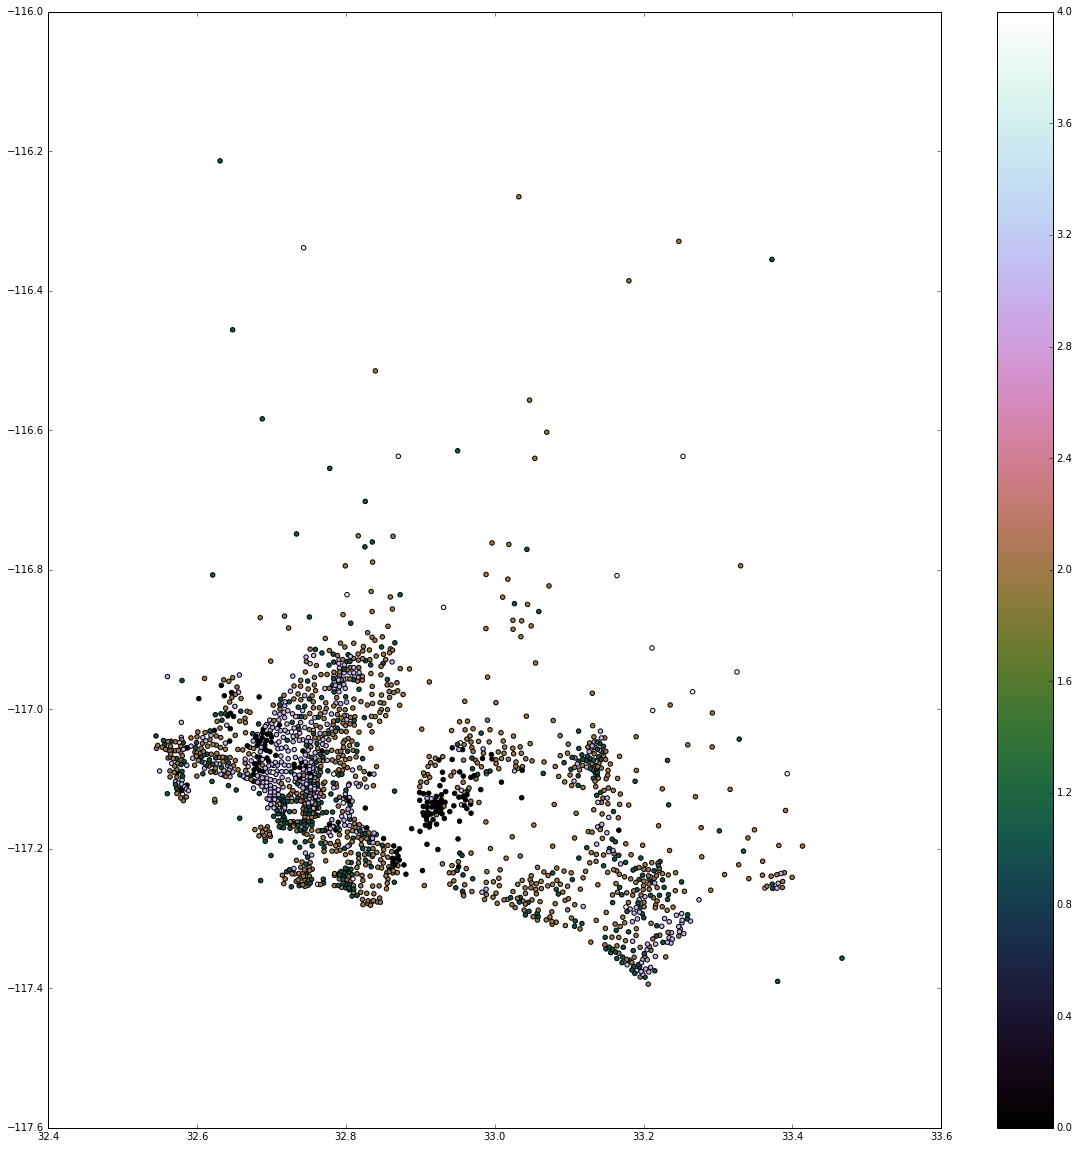

In [396]:
random_state = 170
# Incorrect number of clusters
y_pred = KMeans(n_clusters=5, n_init=10, random_state=random_state).fit_predict(X)

plt.subplots(1,1, figsize=(20,20))
plt.scatter(census_combo[10].astype(float), census_combo[11].astype(float), c=y_pred, cmap='cubehelix')
plt.colorbar()


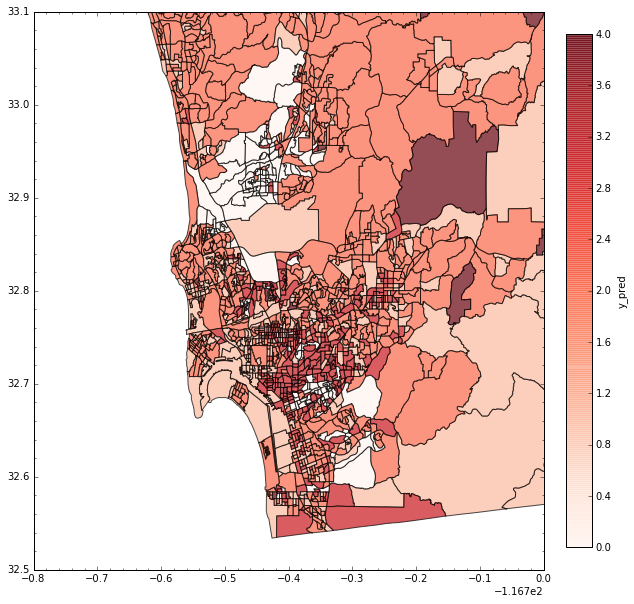

In [397]:
fig,ax = plt.subplots(1,1, figsize=(10,10))
patches = []
for i in range(0,len(sdcounty_index)): 
    barf = pd.DataFrame(shapes[sdcounty_index[i]].points)
    poly = plt.Polygon(barf[[0,1]], fc='none', ec='k', alpha=0.7)
    patches.append(poly)
    #plt.gca().add_patch(poly)

colors = y_pred
p = PatchCollection(patches, cmap='Reds', alpha=0.7)
p.set_array(np.array(colors))
p.set_clim([min(colors),max(colors)])
ax.add_collection(p)
plt.colorbar(p, fraction=0.046, pad=0.04, shrink=1.0, label='y_pred')

#plt.plot(lighting['Geolocation (Longitude)'], lighting['Geolocation (Latitude)'], 'k.')
#plt.plot(graffiti['Geolocation (Longitude)'], graffiti['Geolocation (Latitude)'], 'bs', mfc='none', mec='b')
#plt.plot(dump['Geolocation (Longitude)'], dump['Geolocation (Latitude)'], 'r.')

plt.ylim(32.5,33.1)
plt.xlim(-117.5,-116.7)

#plt.axis('scaled')
plt.minorticks_on()

plt.show()

In [393]:
from sklearn.metrics import silhouette_samples, silhouette_score

In [400]:
silhouette_avg = silhouette_score(X, y_pred)
print silhouette_avg

0.188818502978


In [406]:
cluster_start = np.arange(5,50,5)
for i in cluster_start: 
    y_pred = KMeans(n_clusters=i, n_init=25, random_state=random_state).fit_predict(X)
    silhouette_avg = silhouette_score(X, y_pred)
    
    print("For n_clusters =", i, "The average silhouette_score is :", silhouette_avg)



('For n_clusters =', 5, 'The average silhouette_score is :', 0.18954920770259498)
('For n_clusters =', 10, 'The average silhouette_score is :', 0.19261669215028998)
('For n_clusters =', 15, 'The average silhouette_score is :', 0.16226202435795206)
('For n_clusters =', 20, 'The average silhouette_score is :', 0.14897433255210094)
('For n_clusters =', 25, 'The average silhouette_score is :', 0.14444159542714768)
('For n_clusters =', 30, 'The average silhouette_score is :', 0.1533157735706992)
('For n_clusters =', 35, 'The average silhouette_score is :', 0.14509799963620512)
('For n_clusters =', 40, 'The average silhouette_score is :', 0.14524052850185387)
('For n_clusters =', 45, 'The average silhouette_score is :', 0.13742316593250911)


In [421]:
db = DBSCAN(eps=0.6, min_samples=10).fit(X)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)

print('Estimated number of clusters: %d' % n_clusters_)
print("Silhouette Coefficient: %0.3f" % metrics.silhouette_score(X, labels))

Estimated number of clusters: 2
Silhouette Coefficient: -0.168
